#### DR Preprocessing Comparison
Need to figure out the best way to reduce the dimensionality of the scRNA-seq data prior to calculating EMDs for subpopulation comparison.

In [1]:
# load files and packages
from fst_utils import *
from fcc_utils import *
from fcc_DRs import *
from utilityfunctions import *

%matplotlib inline

Using TensorFlow backend.


In [58]:
# reload functions when editing file
import sys
del sys.modules['utilityfunctions']
from utilityfunctions import *

Read in data files and associate barcodes with RNA counts

In [2]:
%%time
# untreated control BRAF melanoma cell line (SKMEL5)
U = RNA_counts.from_file(datafile='untreated/untreated_raw.csv.gz', cells_axis=1, barcodefile='untreated/Untreated_LineageBC_cellBC.csv')
# treated, idling BRAF melanoma cell line (SKMEL5)
I = RNA_counts.from_file(datafile='idling/treated_raw.csv.gz', cells_axis=1, barcodefile='idling/Treated_LineageBC_cellBC.csv')

CPU times: user 32.6 s, sys: 5.68 s, total: 38.3 s
Wall time: 39.8 s


In [3]:
top20 = list(range(1,21))

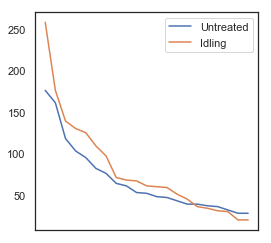

In [4]:
# plot abundance of barcodes to use for distance calcs
plt.figure(figsize=(4,4))
U.barcode_counts(IDs=U.top_barcodes(top20)).plot(label='Untreated', legend=True)
I.barcode_counts(IDs=U.top_barcodes(top20)).plot(label='Idling', legend=True)
plt.show()

In [5]:
# get list of codes to use throughout the rest of analysis
# top 20 codes in Untreated control set
selected_codes = U.top_barcodes(top20)

Perform PCA on each dataset to prime DRs

In [6]:
%%time 
# perform PCA with 100 components on untreated cells, arcsinh-normalized fractional counts
U_PCA = fcc_PCA(matrix=U.arcsinh_norm(norm='l1'), barcodes=U.barcodes, n_components=100)

CPU times: user 15.1 s, sys: 2.6 s, total: 17.7 s
Wall time: 12.6 s


In [7]:
%%time 
# perform PCA with 100 components on idling cells, arcsinh-normalized fractional counts
I_PCA = fcc_PCA(matrix=I.arcsinh_norm(norm='l1'), barcodes=I.barcodes, n_components=100)

CPU times: user 17.4 s, sys: 3.04 s, total: 20.5 s
Wall time: 14.6 s


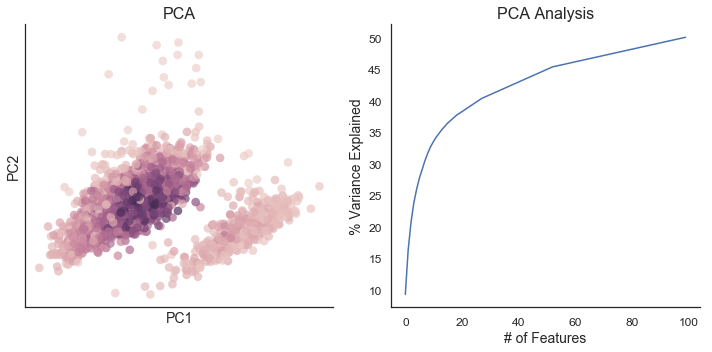

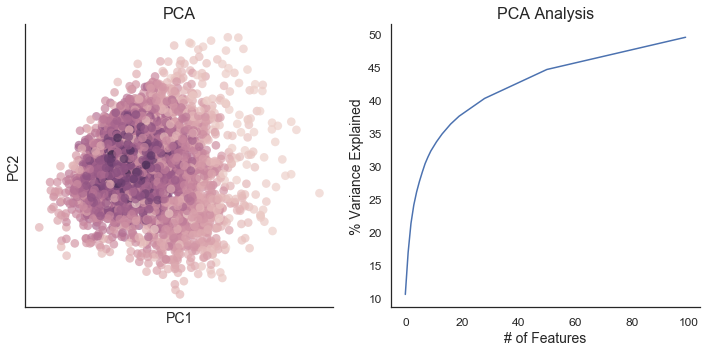

In [8]:
# visualize both PCAs
U_PCA.plot()
I_PCA.plot()

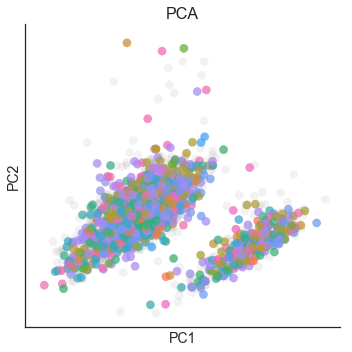

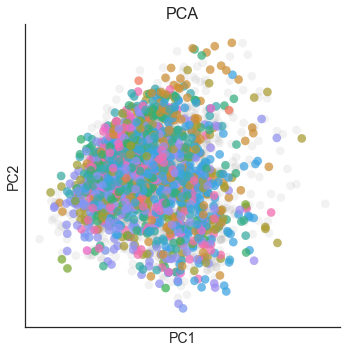

In [9]:
U_PCA.plot_barcodes(selected_codes)
I_PCA.plot_barcodes(selected_codes)

Now, for each of our *selected_codes*, calculate a distance matrix from the null (whole population) within each group, and plot.

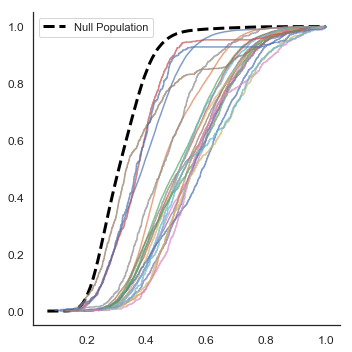

CPU times: user 34.5 s, sys: 1.35 s, total: 35.8 s
Wall time: 36.3 s


In [61]:
%%time
U_out_PCA = compare_barcode_distances(obj=U_PCA, barcodes=selected_codes)

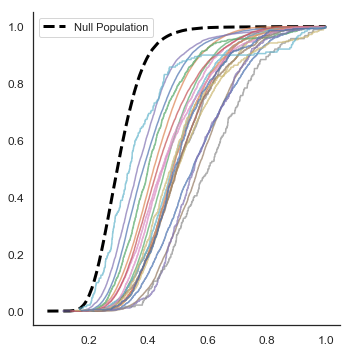

CPU times: user 54.5 s, sys: 3.3 s, total: 57.8 s
Wall time: 58.6 s


In [62]:
%%time
I_out_PCA = compare_barcode_distances(obj=I_PCA, barcodes=selected_codes)

In [63]:
%%time
# range of top 20 barcodes in untreated dataset is 20 to 180 cells. create 'standard curve' of n_cells to determine noise threshold. 
U_curve_PCA = cell_bias_curve(obj=U_PCA, pop_sizes=np.arange(20, 181, 10), iter=5)

CPU times: user 2min 3s, sys: 4.94 s, total: 2min 8s
Wall time: 2min 10s


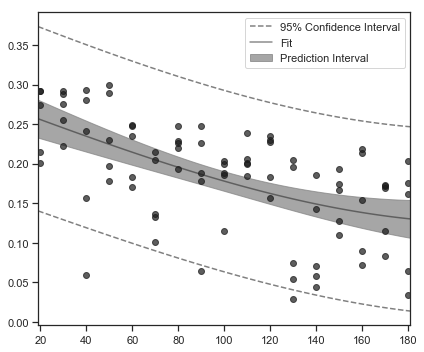

In [64]:
# plot 2nd degree polynomial regression
U_p, U_pi, U_ci = easy_regression(x=U_curve_PCA.melt(id_vars='n_cells')['n_cells'], 
                                  y=U_curve_PCA.melt(id_vars='n_cells')['value'], deg=3)

Do the same as above for __Idling__ dataset

In [65]:
%%time
# range of top 20 barcodes in idling dataset is 20 to 260 cells. create 'standard curve' of n_cells to determine noise threshold. 
I_curve_PCA = cell_bias_curve(obj=I_PCA, pop_sizes=np.arange(20, 261, 10), iter=5)

CPU times: user 4min 43s, sys: 11.5 s, total: 4min 55s
Wall time: 5min 1s


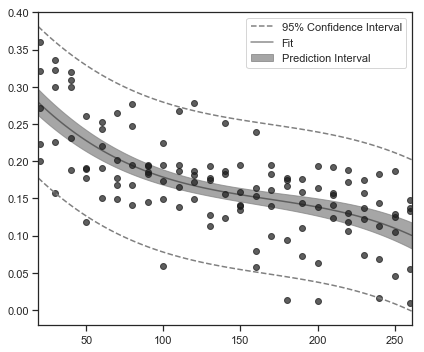

In [66]:
# plot 2nd degree polynomial regression
I_p, I_pi, I_ci = easy_regression(x=I_curve_PCA.melt(id_vars='n_cells')['n_cells'], 
                                  y=I_curve_PCA.melt(id_vars='n_cells')['value'], deg=3)

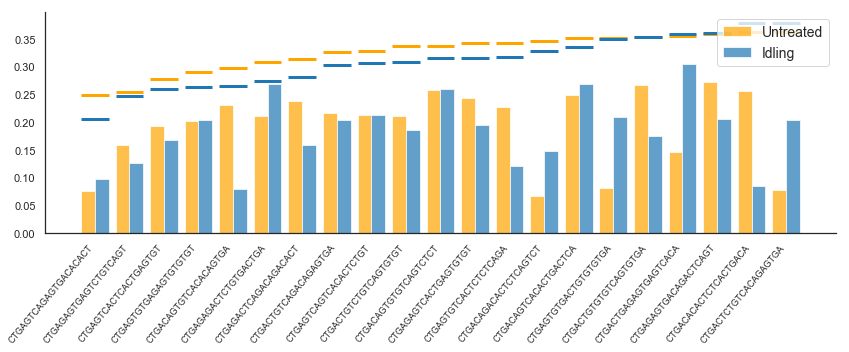

In [67]:
# plot results against acceptance criteria for each dataset (untreated and idling)
plt.figure(figsize=(12,5))
plt.bar(x=U_out_PCA.code, height=U_out_PCA.EMD, align='edge', width=-0.4, label='Untreated', color='orange', alpha=0.7)
plt.bar(x=I_out_PCA.code, height=I_out_PCA.EMD, align='edge', width=0.4, label='Idling', color='#1f77b4', alpha=0.7)
plt.hlines(y=np.polyval(p=U_p, x=U.barcode_counts(selected_codes)) + regression_intervals(x=U_curve_PCA.melt(id_vars='n_cells')['n_cells'], 
                                  y=U_curve_PCA.melt(id_vars='n_cells')['value'],
                                  p=U_p, x_range=list(U.barcode_counts(selected_codes)))[0], 
           xmin=np.arange(0,36)-0.4, xmax=np.arange(0,37)+0.4, linewidth=3, color='orange')
plt.hlines(y=np.polyval(p=I_p, x=I.barcode_counts(selected_codes)) + regression_intervals(x=I_curve_PCA.melt(id_vars='n_cells')['n_cells'], 
                                  y=I_curve_PCA.melt(id_vars='n_cells')['value'],
                                  p=I_p, x_range=list(I.barcode_counts(selected_codes)))[0],
           xmin=np.arange(0,36)-0.4, xmax=np.arange(0,37)+0.4, linewidth=3, color='#1f77b4')
plt.xticks(rotation=50, fontsize=9, ha='right')
plt.legend(loc='best',fontsize=14)
sns.despine()
plt.tight_layout()
plt.show()

---
### t-SNE
Primed with 100-component PCA. 

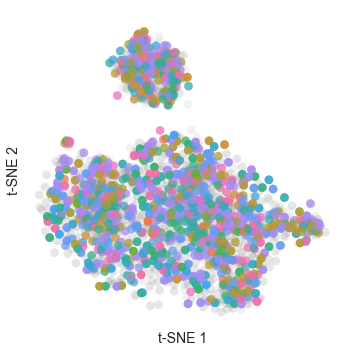

CPU times: user 22.5 s, sys: 1.14 s, total: 23.6 s
Wall time: 23.7 s


In [10]:
%%time 
U_tSNE = fcc_tSNE(U_PCA.results, perplexity=30, barcodes=U_PCA.barcodes) 
U_tSNE.plot_barcodes(ranks=selected_codes)

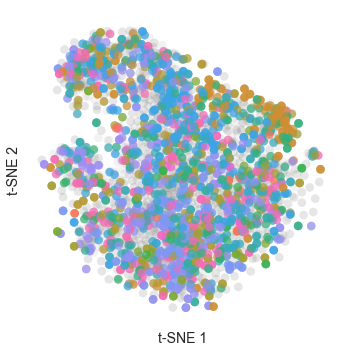

CPU times: user 34.1 s, sys: 2.06 s, total: 36.2 s
Wall time: 36.7 s


In [11]:
%%time 
I_tSNE = fcc_tSNE(I_PCA.results, perplexity=30, barcodes=I_PCA.barcodes) 
I_tSNE.plot_barcodes(ranks=selected_codes)

Now, for each of our *selected_codes*, calculate a distance matrix from the null (whole population) within each group, and plot.

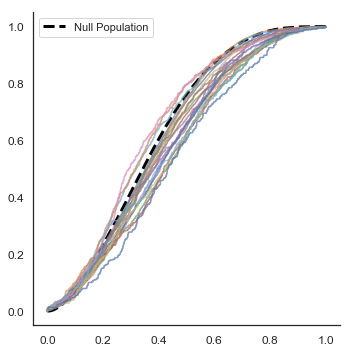

CPU times: user 34 s, sys: 1.43 s, total: 35.4 s
Wall time: 36.5 s


In [12]:
%%time
U_out_tSNE = compare_barcode_distances(obj=U_tSNE, barcodes=selected_codes)

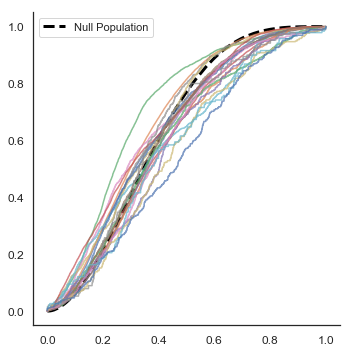

CPU times: user 51.1 s, sys: 2.02 s, total: 53.1 s
Wall time: 54 s


In [13]:
%%time
I_out_tSNE = compare_barcode_distances(obj=I_tSNE, barcodes=selected_codes)

In [14]:
%%time
# range of top 20 barcodes in untreated dataset is 20 to 180 cells. create 'standard curve' of n_cells to determine noise threshold. 
U_curve_tSNE = cell_bias_curve(obj=U_tSNE, pop_sizes=np.arange(20, 181, 10), iter=10)

CPU times: user 4min, sys: 7.6 s, total: 4min 8s
Wall time: 4min 12s


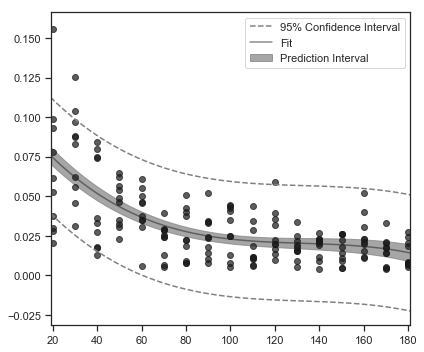

In [19]:
# plot 2nd degree polynomial regression
U_p, U_pi, U_ci = easy_regression(x=U_curve_tSNE.melt(id_vars='n_cells')['n_cells'], 
                                  y=U_curve_tSNE.melt(id_vars='n_cells')['value'], deg=3)

Do the same as above for __Idling__ dataset

In [16]:
%%time
# range of top 20 barcodes in idling dataset is 20 to 260 cells. create 'standard curve' of n_cells to determine noise threshold. 
I_curve_tSNE = cell_bias_curve(obj=I_tSNE, pop_sizes=np.arange(20, 261, 10), iter=10)

CPU times: user 9min 20s, sys: 15.1 s, total: 9min 35s
Wall time: 9min 45s


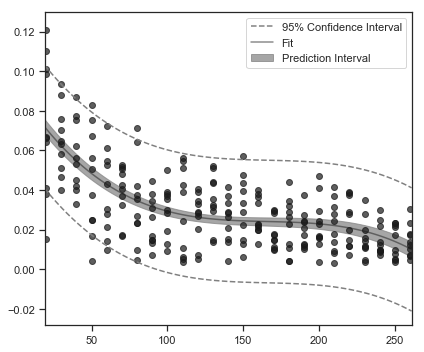

In [20]:
# plot 2nd degree polynomial regression
I_p, I_pi, I_ci = easy_regression(x=I_curve_tSNE.melt(id_vars='n_cells')['n_cells'], 
                                  y=I_curve_tSNE.melt(id_vars='n_cells')['value'], deg=3)

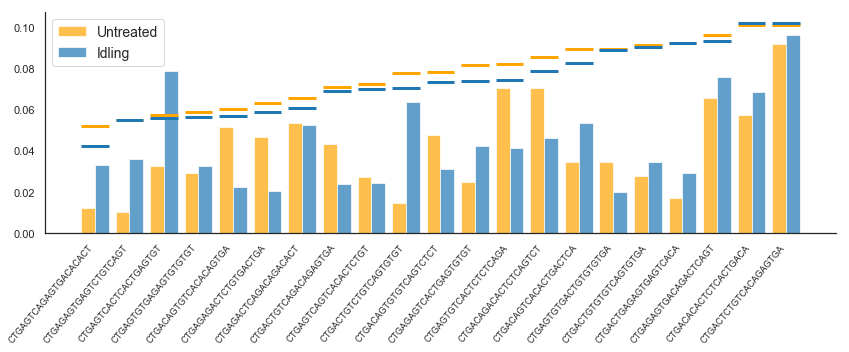

In [21]:
# plot results against acceptance criteria for each dataset (untreated and idling)
plt.figure(figsize=(12,5))
plt.bar(x=U_out_tSNE.code, height=U_out.EMD, align='edge', width=-0.4, label='Untreated', color='orange', alpha=0.7)
plt.bar(x=I_out_tSNE.code, height=I_out.EMD, align='edge', width=0.4, label='Idling', color='#1f77b4', alpha=0.7)
plt.hlines(y=np.polyval(p=U_p, x=U.barcode_counts(selected_codes)) + regression_intervals(x=U_curve_tSNE.melt(id_vars='n_cells')['n_cells'], 
                                  y=U_curve_tSNE.melt(id_vars='n_cells')['value'],
                                  p=U_p, x_range=list(U.barcode_counts(selected_codes)))[0], 
           xmin=np.arange(0,36)-0.4, xmax=np.arange(0,37)+0.4, linewidth=3, color='orange')
plt.hlines(y=np.polyval(p=I_p, x=I.barcode_counts(selected_codes)) + regression_intervals(x=I_curve_tSNE.melt(id_vars='n_cells')['n_cells'], 
                                  y=I_curve_tSNE.melt(id_vars='n_cells')['value'],
                                  p=I_p, x_range=list(I.barcode_counts(selected_codes)))[0],
           xmin=np.arange(0,36)-0.4, xmax=np.arange(0,37)+0.4, linewidth=3, color='#1f77b4')
plt.xticks(rotation=50, fontsize=9, ha='right')
plt.legend(loc='best',fontsize=14)
sns.despine()
plt.tight_layout()
plt.show()

---
### UMAP
Primed with 100-component PCA. 

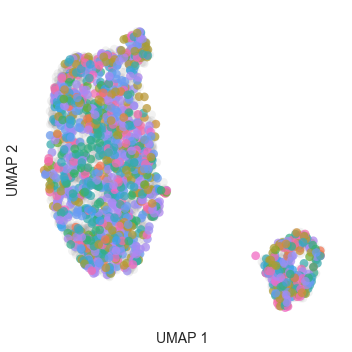

CPU times: user 7.98 s, sys: 720 ms, total: 8.7 s
Wall time: 8.9 s


In [38]:
%%time 
U_UMAP = fcc_UMAP(U_PCA.results, perplexity=30, barcodes=U_PCA.barcodes) 
U_UMAP.plot_barcodes(ranks=selected_codes)

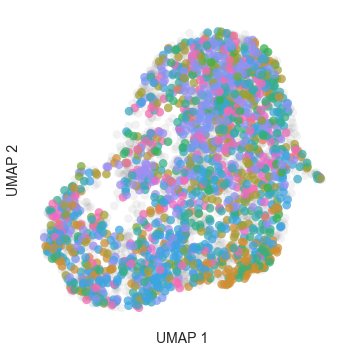

CPU times: user 9.73 s, sys: 576 ms, total: 10.3 s
Wall time: 9.86 s


In [39]:
%%time 
I_UMAP = fcc_UMAP(I_PCA.results, perplexity=30, barcodes=I_PCA.barcodes) 
I_UMAP.plot_barcodes(ranks=selected_codes)

Now, for each of our *selected_codes*, calculate a distance matrix from the null (whole population) within each group, and plot.

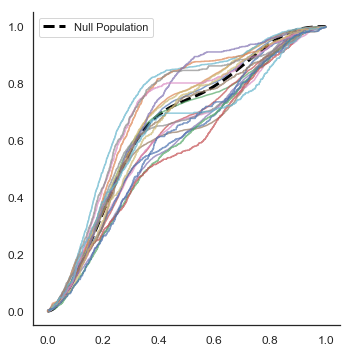

CPU times: user 33.3 s, sys: 1.34 s, total: 34.6 s
Wall time: 35.5 s


In [40]:
%%time
U_out_UMAP = compare_barcode_distances(obj=U_UMAP, barcodes=selected_codes)


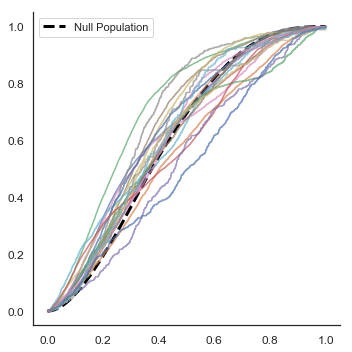

CPU times: user 53.3 s, sys: 2.38 s, total: 55.7 s
Wall time: 57.2 s


In [41]:
%%time
I_out_UMAP = compare_barcode_distances(obj=I_UMAP, barcodes=selected_codes)


In [26]:
%%time
# range of top 20 barcodes in untreated dataset is 20 to 180 cells. create 'standard curve' of n_cells to determine noise threshold. 
U_curve_UMAP = cell_bias_curve(obj=U_UMAP, pop_sizes=np.arange(20, 181, 10), iter=10)

CPU times: user 3min 57s, sys: 6.62 s, total: 4min 4s
Wall time: 4min 8s


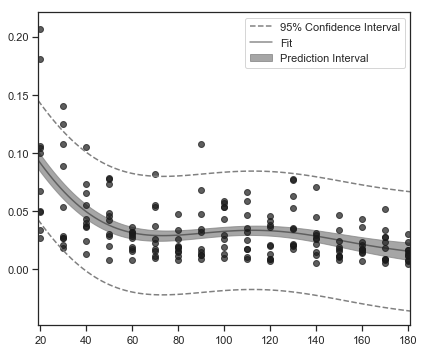

In [52]:
# plot 2nd degree polynomial regression
U_p, U_pi, U_ci = easy_regression(x=U_curve_UMAP.melt(id_vars='n_cells')['n_cells'], 
                                  y=U_curve_UMAP.melt(id_vars='n_cells')['value'], deg=6)

Do the same as above for __Idling__ dataset

In [28]:
%%time
# range of top 20 barcodes in idling dataset is 20 to 260 cells. create 'standard curve' of n_cells to determine noise threshold. 
I_curve_UMAP = cell_bias_curve(obj=I_UMAP, pop_sizes=np.arange(20, 261, 10), iter=5)

CPU times: user 4min 40s, sys: 8.83 s, total: 4min 49s
Wall time: 4min 54s


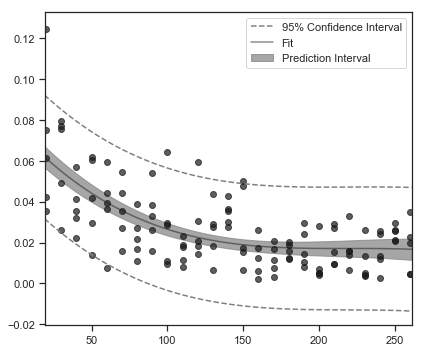

In [45]:
# plot 2nd degree polynomial regression
I_p, I_pi, I_ci = easy_regression(x=I_curve_UMAP.melt(id_vars='n_cells')['n_cells'], 
                                  y=I_curve_UMAP.melt(id_vars='n_cells')['value'], deg=3)

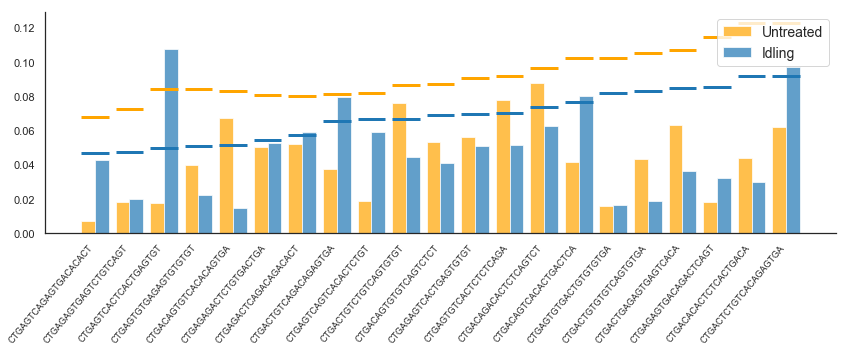

In [53]:
# plot results against acceptance criteria for each dataset (untreated and idling)
plt.figure(figsize=(12,5))
plt.bar(x=U_out.code, height=U_out_UMAP.EMD, align='edge', width=-0.4, label='Untreated', color='orange', alpha=0.7)
plt.bar(x=I_out.code, height=I_out_UMAP.EMD, align='edge', width=0.4, label='Idling', color='#1f77b4', alpha=0.7)
plt.hlines(y=np.polyval(p=U_p, x=U.barcode_counts(selected_codes)) + regression_intervals(x=U_curve_UMAP.melt(id_vars='n_cells')['n_cells'], 
                                  y=U_curve_UMAP.melt(id_vars='n_cells')['value'],
                                  p=U_p, x_range=list(U.barcode_counts(selected_codes)))[0], 
           xmin=np.arange(0,36)-0.4, xmax=np.arange(0,37)+0.4, linewidth=3, color='orange')
plt.hlines(y=np.polyval(p=I_p, x=I.barcode_counts(selected_codes)) + regression_intervals(x=I_curve_UMAP.melt(id_vars='n_cells')['n_cells'], 
                                  y=I_curve_UMAP.melt(id_vars='n_cells')['value'],
                                  p=I_p, x_range=list(I.barcode_counts(selected_codes)))[0], 
           xmin=np.arange(0,36)-0.4, xmax=np.arange(0,37)+0.4, linewidth=3, color='#1f77b4')
plt.xticks(rotation=50, fontsize=9, ha='right')
plt.legend(loc='best',fontsize=14)
sns.despine()
plt.tight_layout()
plt.show()

---
### DCA
Feature selection using DCA

In [50]:
%time U_DCA = fcc_DCA(matrix=U.counts, barcodes=U.barcodes, norm='arcsinh')

DCA: Successfully preprocessed 17172 genes and 2886 cells.
Calculating low dimensional representations...
Calculating reconstructions...
CPU times: user 23min 5s, sys: 5min 23s, total: 28min 29s
Wall time: 13min 32s


In [51]:
%time I_DCA = fcc_DCA(matrix=I.counts, barcodes=I.barcodes, norm='arcsinh')

DCA: Successfully preprocessed 17193 genes and 3524 cells.
Calculating low dimensional representations...
Calculating reconstructions...
CPU times: user 37min 48s, sys: 7min 58s, total: 45min 47s
Wall time: 22min 59s


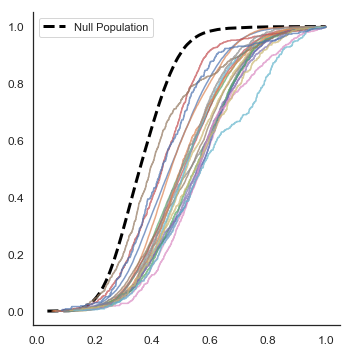

CPU times: user 7min 35s, sys: 6min 3s, total: 13min 38s
Wall time: 13min 41s


In [52]:
%%time
U_out_DCA = compare_barcode_distances(obj=U_DCA, barcodes=selected_codes)

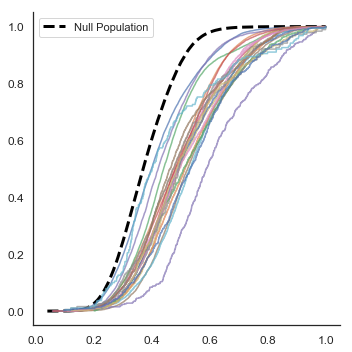

CPU times: user 11min 17s, sys: 8min 58s, total: 20min 16s
Wall time: 20min 20s


In [53]:
%%time
I_out_DCA = compare_barcode_distances(obj=I_DCA, barcodes=selected_codes)

In [54]:
%%time
# range of top 20 barcodes in untreated dataset is 20 to 180 cells. create 'standard curve' of n_cells to determine noise threshold. 
U_curve_DCA = cell_bias_curve(obj=U_DCA, pop_sizes=np.arange(20, 181, 10), iter=10)

CPU times: user 11min 48s, sys: 6min 29s, total: 18min 17s
Wall time: 18min 21s


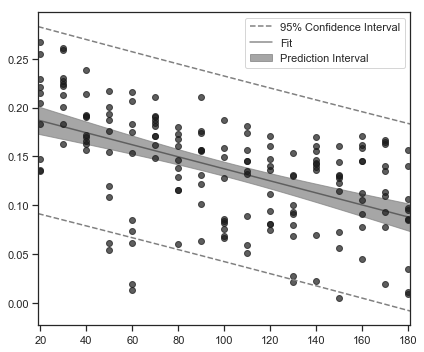

In [55]:
# plot 2nd degree polynomial regression
U_p, U_pi, U_ci = easy_regression(x=U_curve_DCA.melt(id_vars='n_cells')['n_cells'], 
                                  y=U_curve_DCA.melt(id_vars='n_cells')['value'], deg=1)

Do the same as above for __Idling__ dataset

In [56]:
%%time
# range of top 20 barcodes in idling dataset is 20 to 260 cells. create 'standard curve' of n_cells to determine noise threshold. 
I_curve_DCA = cell_bias_curve(obj=I_DCA, pop_sizes=np.arange(20, 261, 10), iter=5)

CPU times: user 17min 37s, sys: 10min 37s, total: 28min 15s
Wall time: 28min 26s


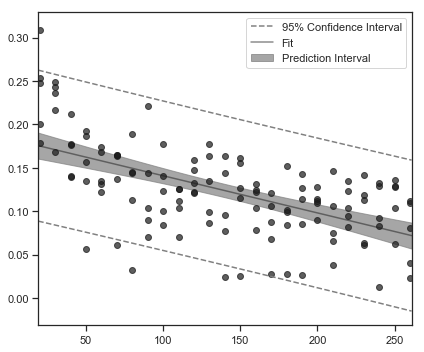

In [57]:
# plot 2nd degree polynomial regression
I_p, I_pi, I_ci = easy_regression(x=I_curve_DCA.melt(id_vars='n_cells')['n_cells'], 
                                  y=I_curve_DCA.melt(id_vars='n_cells')['value'], deg=1)

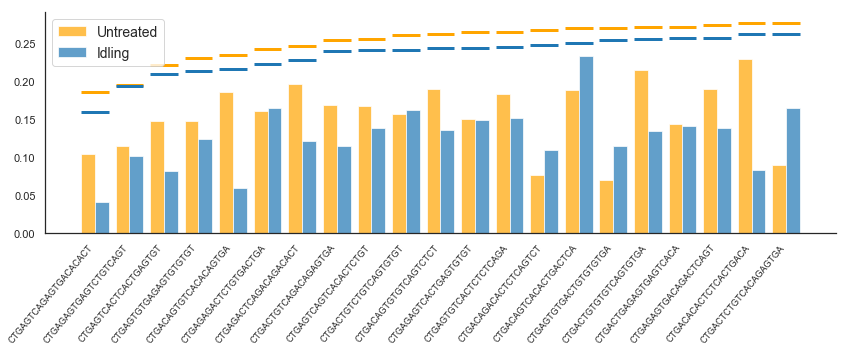

In [58]:
# plot results against acceptance criteria for each dataset (untreated and idling)
plt.figure(figsize=(12,5))
plt.bar(x=U_out_DCA.code, height=U_out.EMD, align='edge', width=-0.4, label='Untreated', color='orange', alpha=0.7)
plt.bar(x=I_out_DCA.code, height=I_out.EMD, align='edge', width=0.4, label='Idling', color='#1f77b4', alpha=0.7)
plt.hlines(y=np.polyval(p=U_p, x=U.barcode_counts(selected_codes)) + regression_intervals(x=U_curve_DCA.melt(id_vars='n_cells')['n_cells'], 
                                  y=U_curve_DCA.melt(id_vars='n_cells')['value'],
                                  p=U_p, x_range=list(U.barcode_counts(selected_codes)))[0], 
           xmin=np.arange(0,36)-0.4, xmax=np.arange(0,37)+0.4, linewidth=3, color='orange')
plt.hlines(y=np.polyval(p=I_p, x=I.barcode_counts(selected_codes)) + regression_intervals(x=I_curve_DCA.melt(id_vars='n_cells')['n_cells'], 
                                  y=I_curve_DCA.melt(id_vars='n_cells')['value'],
                                  p=I_p, x_range=list(I.barcode_counts(selected_codes)))[0], 
           xmin=np.arange(0,36)-0.4, xmax=np.arange(0,37)+0.4, linewidth=3, color='#1f77b4')
plt.xticks(rotation=50, fontsize=9, ha='right')
plt.legend(loc='best',fontsize=14)
sns.despine()
plt.tight_layout()
plt.show()

---
### Feature-Selected t-SNE
Feature selection, projected using t-SNE

In [69]:
# read in cell cycle genes
cell_cycle = pd.read_csv('metadata_combined.csv')

In [71]:
U_cell_cycle = pd.read_csv('untreated/untreated_metadata.csv')
I_cell_cycle = pd.read_csv('idling/treated_metadata.csv')
U_cell_cycle.rename(columns={'Unnamed: 0':'Cell Barcode'}, inplace=True)
I_cell_cycle.rename(columns={'Unnamed: 0':'Cell Barcode'}, inplace=True)

In [81]:
# select 150 most variable genes
U_vg = RNA_counts.var_select(counts_obj=U, n_features=150)
I_vg = RNA_counts.var_select(counts_obj=I, n_features=150)

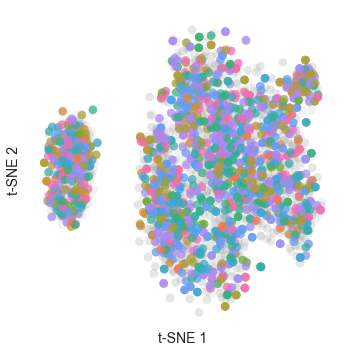

CPU times: user 27.3 s, sys: 1.38 s, total: 28.7 s
Wall time: 29 s


In [82]:
%%time
U_vg_tSNE = fcc_tSNE(matrix=U_vg.arcsinh_norm(norm='l1'), barcodes=U_vg.barcodes, perplexity=30)
U_vg_tSNE.plot_barcodes(ranks=selected_codes)

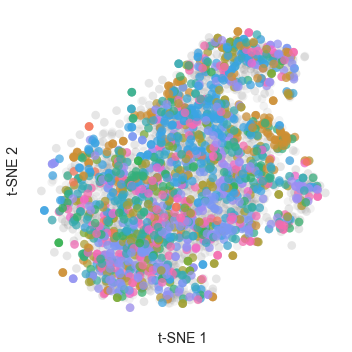

CPU times: user 34 s, sys: 2 s, total: 36 s
Wall time: 36.8 s


In [83]:
%%time
I_vg_tSNE = fcc_tSNE(matrix=I_vg.arcsinh_norm(norm='l1'), barcodes=I_vg.barcodes, perplexity=30)
I_vg_tSNE.plot_barcodes(ranks=selected_codes)

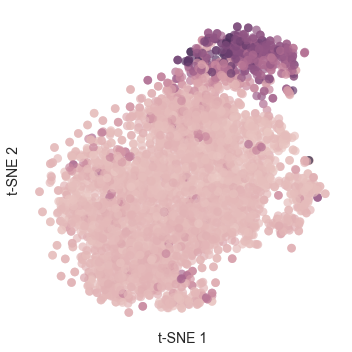

In [120]:
plt.figure(figsize=(5,5))
sns.scatterplot(I_vg_tSNE.results[:,0], I_vg_tSNE.results[:,1], s=75, alpha=0.7, hue=I_cell_cycle['G2M.Score']+I_cell_cycle['S.Score'], legend=None, edgecolor='none')
plt.xlabel('t-SNE 1', fontsize=14)
plt.ylabel('t-SNE 2', fontsize=14)
plt.tick_params(labelbottom=False, labelleft=False)
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()
plt.close()

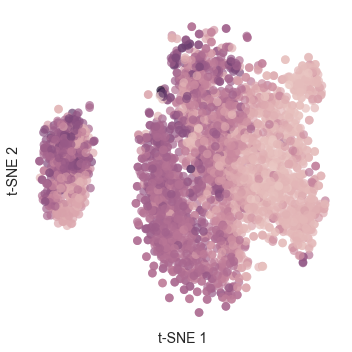

In [119]:
plt.figure(figsize=(5,5))
sns.scatterplot(U_vg_tSNE.results[:,0], U_vg_tSNE.results[:,1], s=75, alpha=0.7, hue=U_cell_cycle['G2M.Score']+U_cell_cycle['S.Score'], legend=None, edgecolor='none')
plt.xlabel('t-SNE 1', fontsize=14)
plt.ylabel('t-SNE 2', fontsize=14)
plt.tick_params(labelbottom=False, labelleft=False)
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()
plt.close()

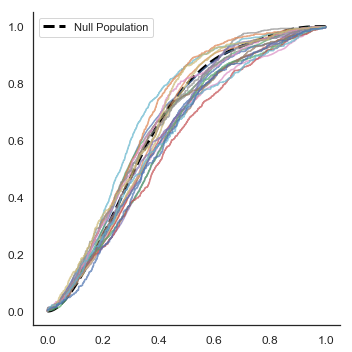

CPU times: user 32.5 s, sys: 1.26 s, total: 33.8 s
Wall time: 34.2 s


In [88]:
%%time
U_out_vg_tSNE = compare_barcode_distances(obj=U_vg_tSNE, barcodes=selected_codes)

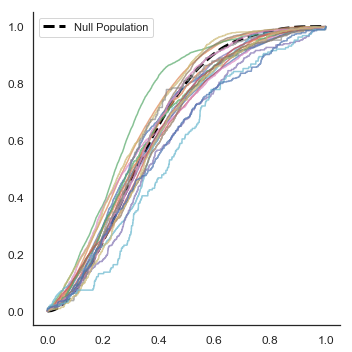

CPU times: user 50.9 s, sys: 1.97 s, total: 52.9 s
Wall time: 53.4 s


In [89]:
%%time
I_out_vg_tSNE = compare_barcode_distances(obj=I_vg_tSNE, barcodes=selected_codes)

In [90]:
%%time
# range of top 20 barcodes in untreated dataset is 20 to 180 cells. create 'standard curve' of n_cells to determine noise threshold. 
U_curve_vg_tSNE = cell_bias_curve(obj=U_vg_tSNE, pop_sizes=np.arange(20, 181, 10), iter=10)

CPU times: user 4min 2s, sys: 7.59 s, total: 4min 10s
Wall time: 4min 17s


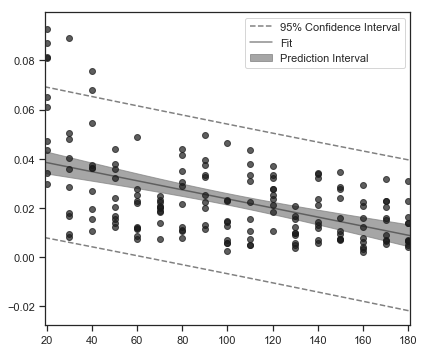

In [91]:
# plot 2nd degree polynomial regression
U_p, U_pi, U_ci = easy_regression(x=U_curve_vg_tSNE.melt(id_vars='n_cells')['n_cells'], 
                                  y=U_curve_vg_tSNE.melt(id_vars='n_cells')['value'], deg=1)

Do the same as above for __Idling__ dataset

In [92]:
%%time
# range of top 20 barcodes in idling dataset is 20 to 260 cells. create 'standard curve' of n_cells to determine noise threshold. 
I_curve_vg_tSNE = cell_bias_curve(obj=I_vg_tSNE, pop_sizes=np.arange(20, 261, 10), iter=5)

CPU times: user 4min 38s, sys: 8.55 s, total: 4min 47s
Wall time: 4min 50s


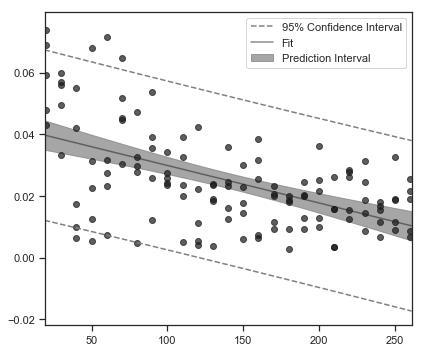

In [93]:
# plot 2nd degree polynomial regression
I_p, I_pi, I_ci = easy_regression(x=I_curve_vg_tSNE.melt(id_vars='n_cells')['n_cells'], 
                                  y=I_curve_vg_tSNE.melt(id_vars='n_cells')['value'], deg=1)

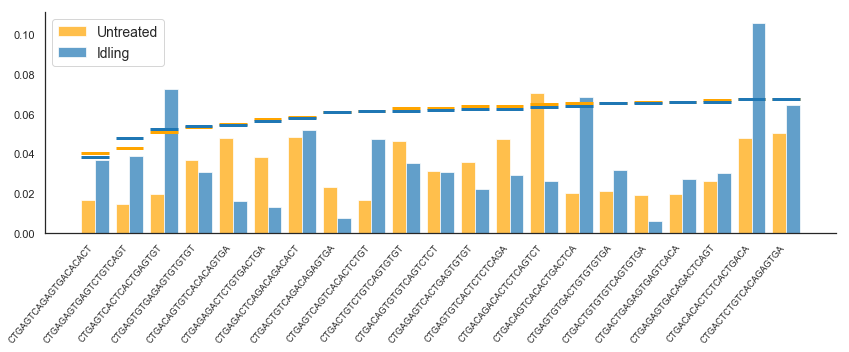

In [94]:
# plot results against acceptance criteria for each dataset (untreated and idling)
plt.figure(figsize=(12,5))
plt.bar(x=U_out_vg_tSNE.code, height=U_out_vg_tSNE.EMD, align='edge', width=-0.4, label='Untreated', color='orange', alpha=0.7)
plt.bar(x=I_out_vg_tSNE.code, height=I_out_vg_tSNE.EMD, align='edge', width=0.4, label='Idling', color='#1f77b4', alpha=0.7)
plt.hlines(y=np.polyval(p=U_p, x=U.barcode_counts(selected_codes)) + regression_intervals(x=U_curve_vg_tSNE.melt(id_vars='n_cells')['n_cells'], 
                                  y=U_curve_vg_tSNE.melt(id_vars='n_cells')['value'],
                                  p=U_p, x_range=list(U.barcode_counts(selected_codes)))[0], 
           xmin=np.arange(0,36)-0.4, xmax=np.arange(0,37)+0.4, linewidth=3, color='orange')
plt.hlines(y=np.polyval(p=I_p, x=I.barcode_counts(selected_codes)) + regression_intervals(x=I_curve_vg_tSNE.melt(id_vars='n_cells')['n_cells'], 
                                  y=I_curve_vg_tSNE.melt(id_vars='n_cells')['value'],
                                  p=I_p, x_range=list(I.barcode_counts(selected_codes)))[0], 
           xmin=np.arange(0,36)-0.4, xmax=np.arange(0,37)+0.4, linewidth=3, color='#1f77b4')
plt.xticks(rotation=50, fontsize=9, ha='right')
plt.legend(loc='best',fontsize=14)
sns.despine()
plt.tight_layout()
plt.show()

---
### Feature-Selected UMAP
Feature selection, projected using UMAP

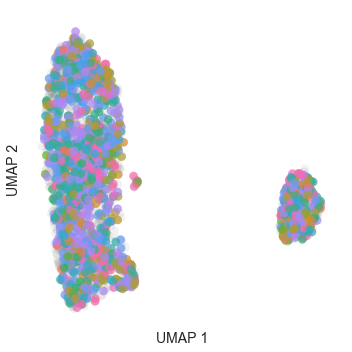

CPU times: user 7.93 s, sys: 426 ms, total: 8.36 s
Wall time: 8.18 s


In [110]:
%%time
U_vg_UMAP = fcc_UMAP(matrix=U_vg.arcsinh_norm(norm='l1'), barcodes=U_vg.barcodes, perplexity=30)
U_vg_UMAP.plot_barcodes(ranks=selected_codes)

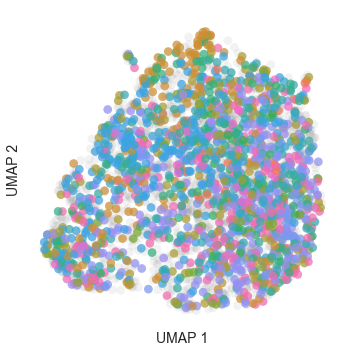

CPU times: user 10.2 s, sys: 491 ms, total: 10.7 s
Wall time: 10.4 s


In [111]:
%%time
I_vg_UMAP = fcc_UMAP(matrix=I_vg.arcsinh_norm(norm='l1'), barcodes=I_vg.barcodes, perplexity=30)
I_vg_UMAP.plot_barcodes(ranks=selected_codes)

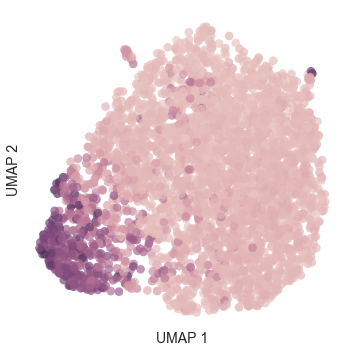

In [114]:
plt.figure(figsize=(5,5))
sns.scatterplot(I_vg_UMAP.results[:,0], I_vg_UMAP.results[:,1], s=75, alpha=0.7, hue=I_cell_cycle['G2M.Score']+I_cell_cycle['S.Score'], legend=None, edgecolor='none')
plt.xlabel('UMAP 1', fontsize=14)
plt.ylabel('UMAP 2', fontsize=14)
plt.tick_params(labelbottom=False, labelleft=False)
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()
plt.close()

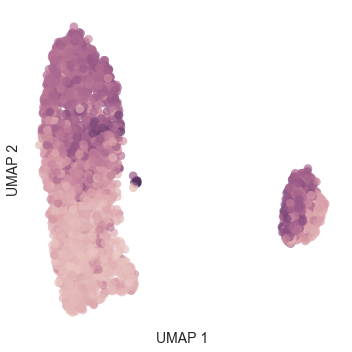

In [129]:
plt.figure(figsize=(5,5))
sns.scatterplot(U_vg_UMAP.results[:,0], U_vg_UMAP.results[:,1], s=75, alpha=0.7, hue=U_cell_cycle['G2M.Score']+U_cell_cycle['S.Score'], legend=None, edgecolor='none')
plt.xlabel('UMAP 1', fontsize=14)
plt.ylabel('UMAP 2', fontsize=14)
plt.tick_params(labelbottom=False, labelleft=False)
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()
plt.close()

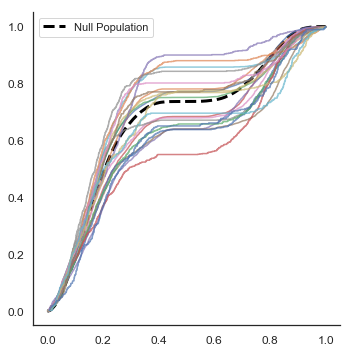

CPU times: user 32.1 s, sys: 1.13 s, total: 33.2 s
Wall time: 33.6 s


In [116]:
%%time
U_out_vg_UMAP = compare_barcode_distances(obj=U_vg_UMAP, barcodes=selected_codes)

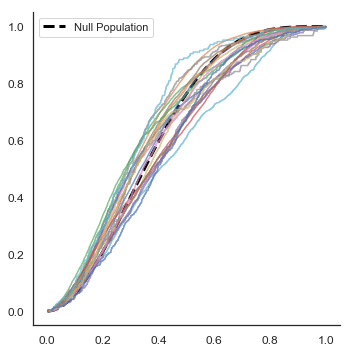

CPU times: user 51.5 s, sys: 1.98 s, total: 53.5 s
Wall time: 54.2 s


In [117]:
%%time
I_out_vg_UMAP = compare_barcode_distances(obj=I_vg_UMAP, barcodes=selected_codes)

In [121]:
%%time
# range of top 20 barcodes in untreated dataset is 20 to 180 cells. create 'standard curve' of n_cells to determine noise threshold. 
U_curve_vg_UMAP = cell_bias_curve(obj=U_vg_UMAP, pop_sizes=np.arange(20, 181, 10), iter=10)

CPU times: user 3min 58s, sys: 6.95 s, total: 4min 5s
Wall time: 4min 10s


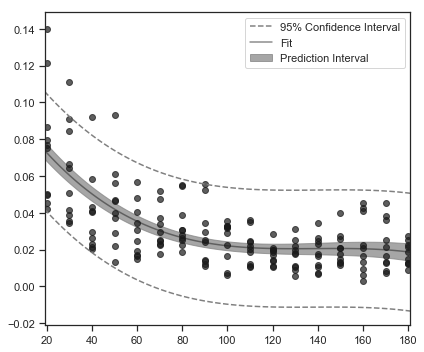

In [126]:
# plot 2nd degree polynomial regression
U_p, U_pi, U_ci = easy_regression(x=U_curve_vg_UMAP.melt(id_vars='n_cells')['n_cells'], 
                                  y=U_curve_vg_UMAP.melt(id_vars='n_cells')['value'], deg=3)

Do the same as above for __Idling__ dataset

In [123]:
%%time
# range of top 20 barcodes in idling dataset is 20 to 260 cells. create 'standard curve' of n_cells to determine noise threshold. 
I_curve_vg_UMAP = cell_bias_curve(obj=I_vg_UMAP, pop_sizes=np.arange(20, 261, 10), iter=5)

CPU times: user 4min 45s, sys: 9.93 s, total: 4min 55s
Wall time: 5min 2s


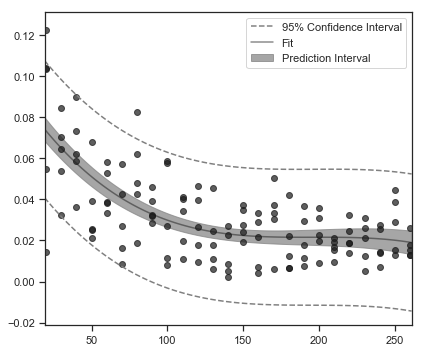

In [127]:
# plot 2nd degree polynomial regression
I_p, I_pi, I_ci = easy_regression(x=I_curve_vg_UMAP.melt(id_vars='n_cells')['n_cells'], 
                                  y=I_curve_vg_UMAP.melt(id_vars='n_cells')['value'], deg=3)

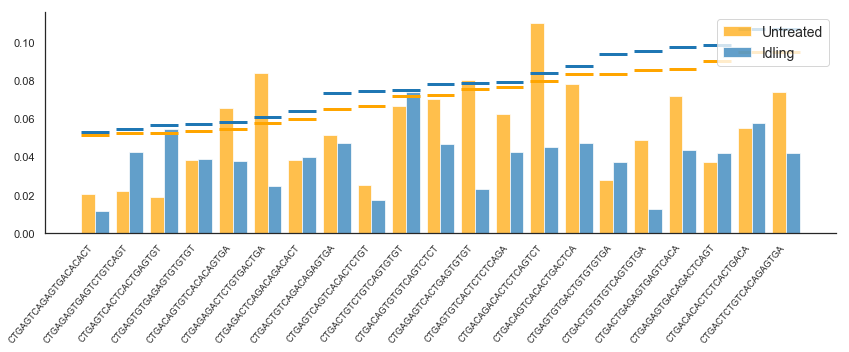

In [128]:
# plot results against acceptance criteria for each dataset (untreated and idling)
plt.figure(figsize=(12,5))
plt.bar(x=U_out_vg_UMAP.code, height=U_out_vg_UMAP.EMD, align='edge', width=-0.4, label='Untreated', color='orange', alpha=0.7)
plt.bar(x=I_out_vg_UMAP.code, height=I_out_vg_UMAP.EMD, align='edge', width=0.4, label='Idling', color='#1f77b4', alpha=0.7)
plt.hlines(y=np.polyval(p=U_p, x=U.barcode_counts(selected_codes)) + regression_intervals(x=U_curve_vg_UMAP.melt(id_vars='n_cells')['n_cells'], 
                                  y=U_curve_vg_UMAP.melt(id_vars='n_cells')['value'],
                                  p=U_p, x_range=list(U.barcode_counts(selected_codes)))[0], 
           xmin=np.arange(0,36)-0.4, xmax=np.arange(0,37)+0.4, linewidth=3, color='orange')
plt.hlines(y=np.polyval(p=I_p, x=I.barcode_counts(selected_codes)) + regression_intervals(x=I_curve_vg_UMAP.melt(id_vars='n_cells')['n_cells'], 
                                  y=I_curve_vg_UMAP.melt(id_vars='n_cells')['value'],
                                  p=I_p, x_range=list(I.barcode_counts(selected_codes)))[0], 
           xmin=np.arange(0,36)-0.4, xmax=np.arange(0,37)+0.4, linewidth=3, color='#1f77b4')
plt.xticks(rotation=50, fontsize=9, ha='right')
plt.legend(loc='best',fontsize=14)
sns.despine()
plt.tight_layout()
plt.show()

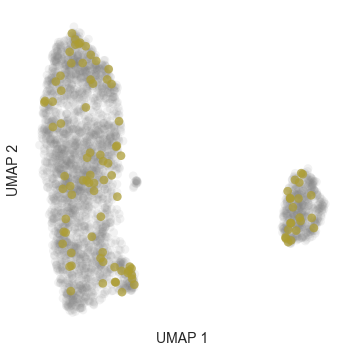

In [137]:
U_vg_UMAP.plot_barcodes(ranks=[selected_codes[4]])

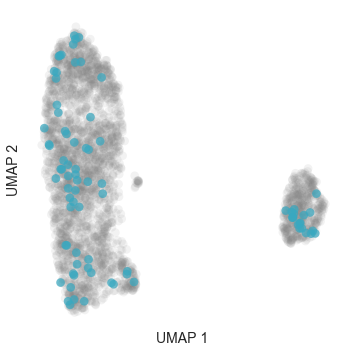

In [138]:
U_vg_UMAP.plot_barcodes(ranks=[selected_codes[5]])

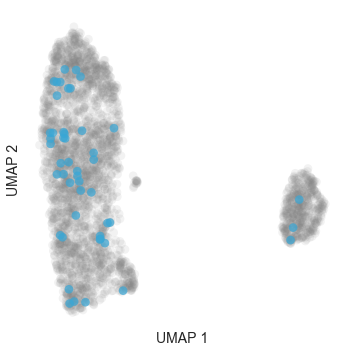

In [139]:
U_vg_UMAP.plot_barcodes(ranks=[selected_codes[11]])

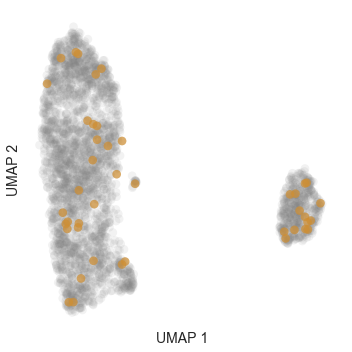

In [140]:
U_vg_UMAP.plot_barcodes(ranks=[selected_codes[13]])